<a href="https://colab.research.google.com/github/GuillermoSainz07/Notebooks-DS/blob/main/Probabilidad_de_incumplimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilidad de incumplimiento

La variable objetivo sera *charge-off*, la cual es una declaración por parte de un acreedor de que es poco probable que se cobre una cantidad de deuda. Por lo tanto la variable objetivo tomara el valor de 1 y 0 en otro caso.

El conjunto de datos tendra 150 *features*. Las caracteristicas incluyen ingresos, edad, puntuaje de credito, propiedad de vivienda, ubicacion de prestatario, cobors y muchos otros. Investigaremos estas 150 variables predictoras para la seleccion de caracteristicas

En la mayoria de los casos de la vida real, no podemos trabajar con datos limpios y completos. Algunos de los problemas potenciales que estamos obligados a encontrar son los datos faltantes, datos categoricos incompletos y caracteristicas irrelevantes. Los algoritmos que podemos utilizar pueden ser potentes, pero sin los datos relevantes o apropiados, el sistema puede no obtener resultados ideales. Por lo tanto una de las areas de enfoque en este caso de estudio sea el procesamiento de datos, seleccion de caracteristicas y el analisis exploratorio de los datos para la limpieza y organizacion

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.style.use('seaborn')

In [ ]:
prestamos = pd.read_csv('/content/LoansData_sample.csv.gz',
                        compression='gzip',
                        low_memory=True)
data = prestamos.copy()

<ipython-input-3-57995a65cd40>:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  prestamos = pd.read_csv('/content/LoansData_sample.csv.gz',


**Preparacion y seleccion de caracteristicas**

La variable objetivo sera `loan_status`. Asi mismo especificamos que:
- **Fully Paid:**

    Prestamos que han sido reembolsados en su totalidad

- **Default:**

    Prestamos que no han estado al dia durante 121 dias o mas
- **Charge Off:**

    Prestamos para los que ya no hay una expectativa razonable de mas pagos

Con el fin de convertir el problema en uno de clasificacion binaria y analizar en detalle el feceto de variables importantes en el estado del prestamos, consideraremos solo 2 categorias. **Fully Paid** y **Charge Off**

In [ ]:
dataset = data.loc[data['loan_status'].isin(['Fully Paid','Charged Off'])]

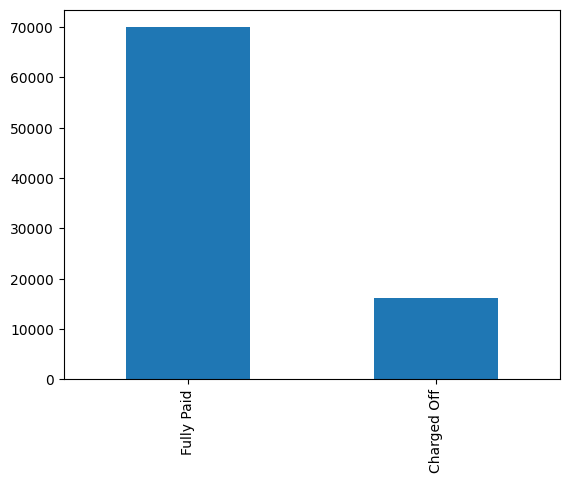

In [ ]:
dataset['loan_status'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
### Dummie variables
dataset = dataset.assign(charged_off = lambda df: df['loan_status']
               .replace(['Fully Paid','Charged Off'],[0,1]))
dataset.drop('loan_status', axis=1, inplace=True)

El conjunto cuenta con 150 caracteristicas, pero no todas son utiles o no todas contribuyen a la variable de prediccion. La eliminacion de caracteristicas de poca importancia puede ayudar a mejorar la precision y reducir la complejidad del modelo. El tiempo y el performance tambien pueden mejorar. Por lo tanto eliminaremos las features que:
- Tengan mas del 30% de datos faltantes
- Caracteristicas no intuitivas
- Eliminar caracteristicas con baja correlacion con la variable predicha

Mas de 30% de datos faltantes

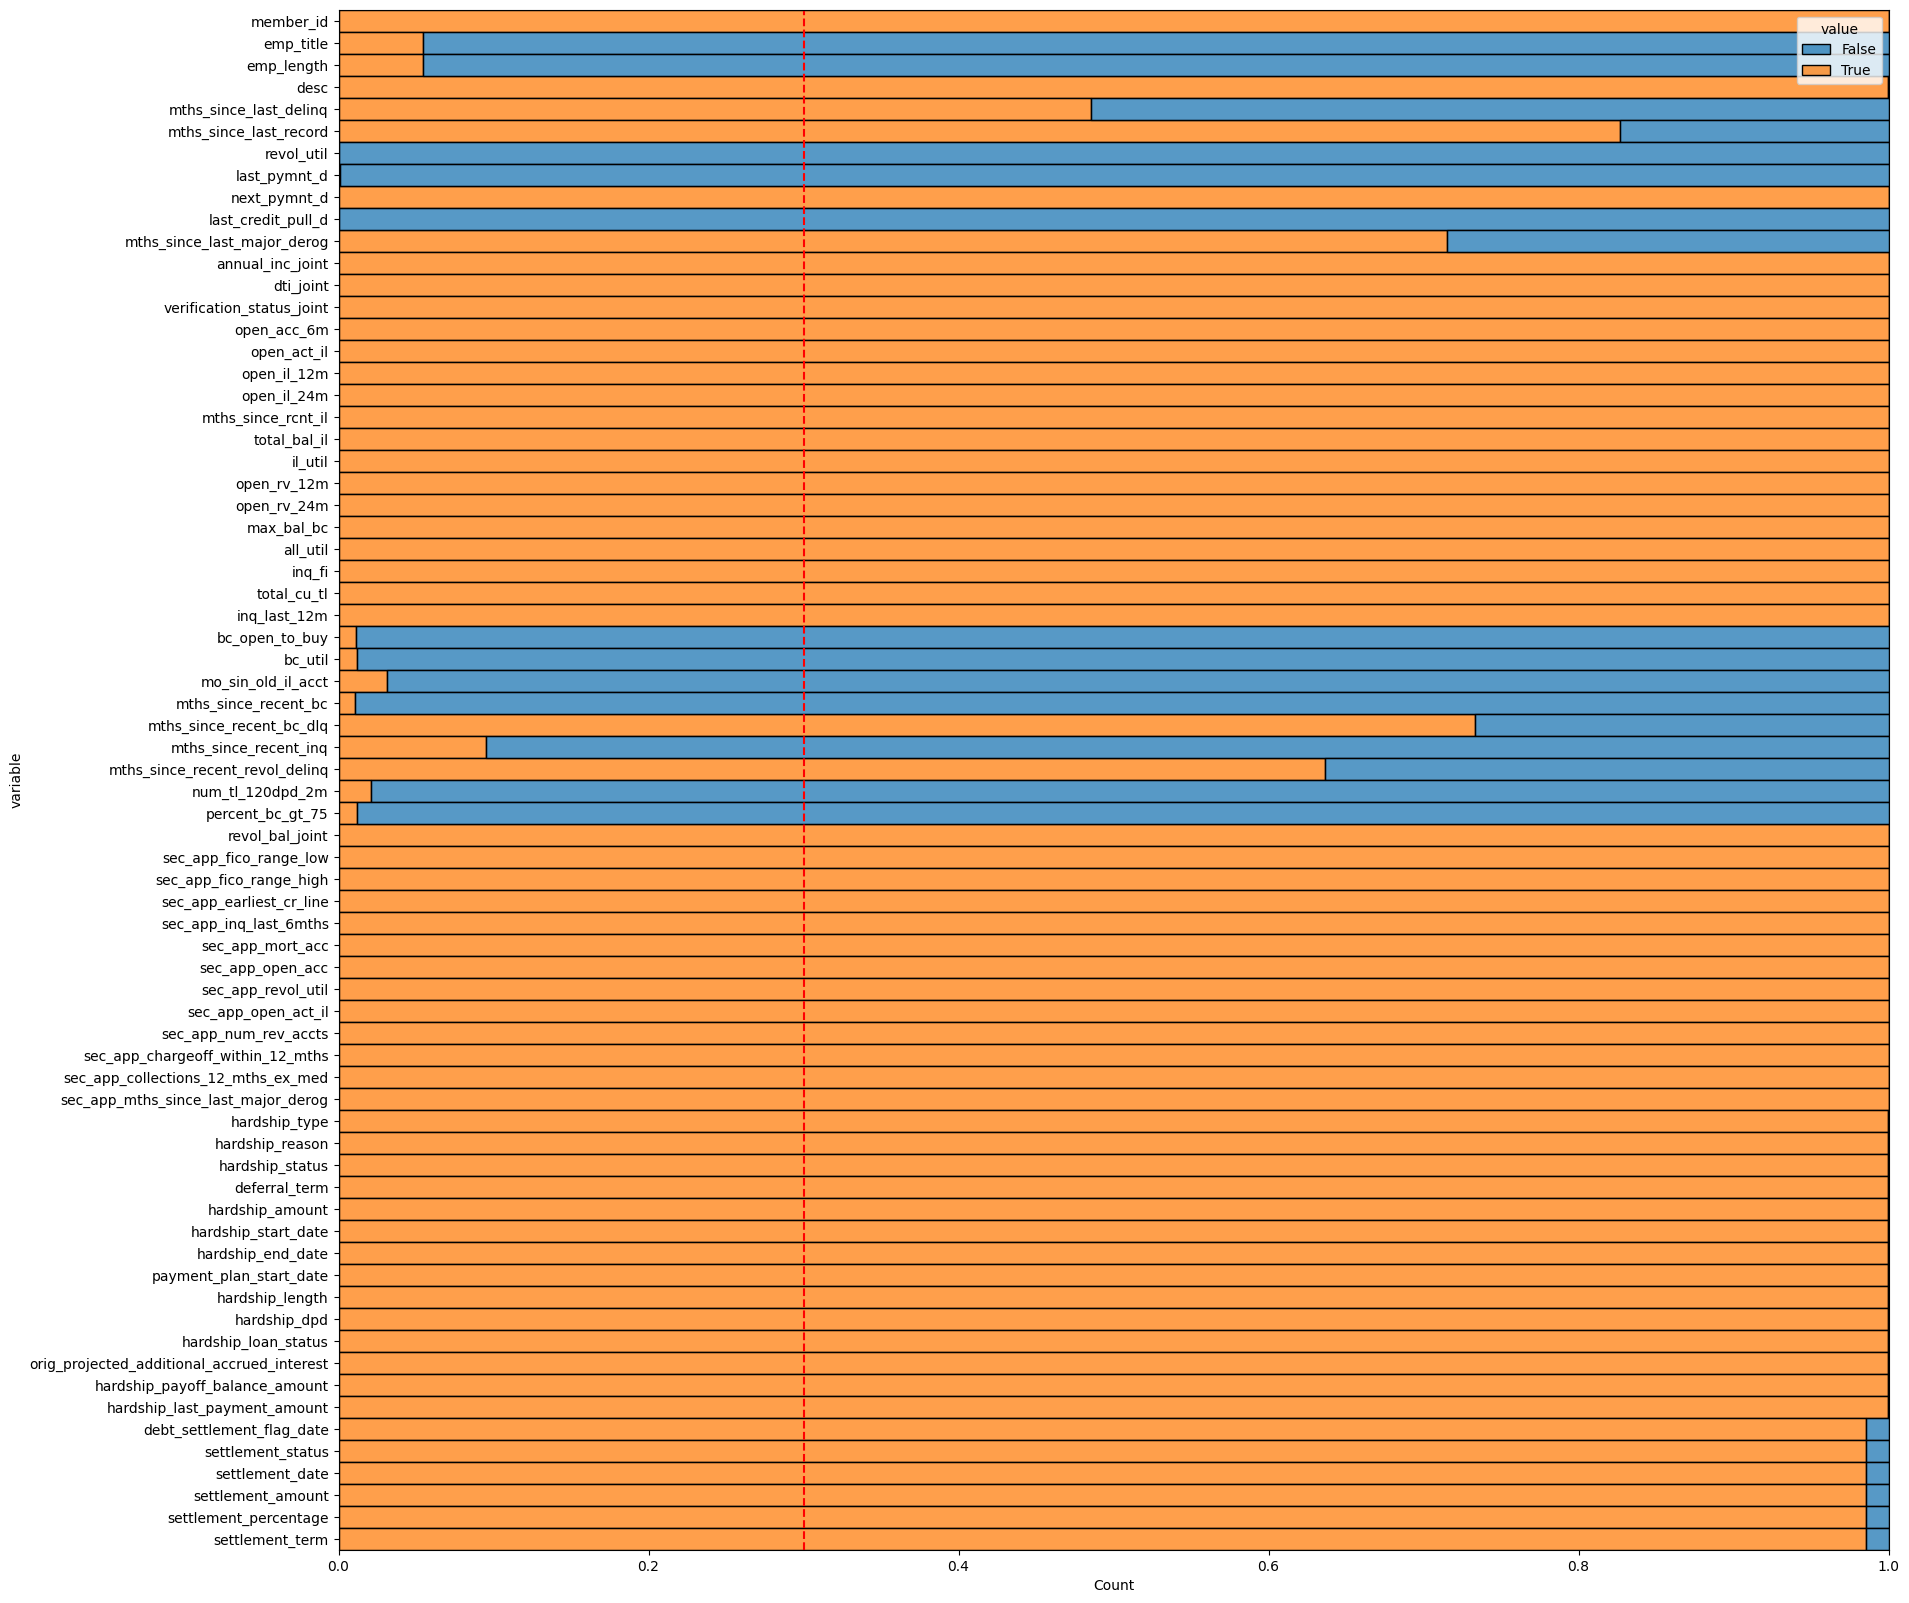

In [ ]:
col_miss = dataset.isna().any()[dataset.isna().any()].index ## Features con datos faltantes
plt.figure(figsize=(20,20))
plt.axvline(x=0.3, color='red',ls='--')
sns.histplot(dataset[col_miss].isna().melt(), y='variable', hue='value',
             multiple='fill')
plt.show()

In [ ]:
miss_values = dataset[col_miss].isna().mean()

In [ ]:
drop_features = miss_values[miss_values > 0.3].index

In [ ]:
dataset.drop(drop_features, axis=1, inplace=True)

In [ ]:
dataset.shape

(86138, 93)

Eliminar features no intuitivas

In [ ]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc',
             'application_type', 'dti', 'earliest_cr_line', 'emp_length',
             'emp_title', 'fico_range_high', 'fico_range_low', 'grade',
             'home_ownership', 'id', 'initial_list_status', 'installment',
             'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc',
             'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
             'sub_grade', 'term', 'title', 'total_acc', 'verification_status',
             'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op',
             'mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

In [ ]:
drop_list = [col for col in dataset.columns if col not in keep_list]
dataset.drop(drop_list, axis=1, inplace=True)
dataset.shape

(86138, 39)

Eliminar features no correlacionadas < 0.03

<ipython-input-16-a7ee0d7bc77e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(dataset.corr()[['charged_off']])


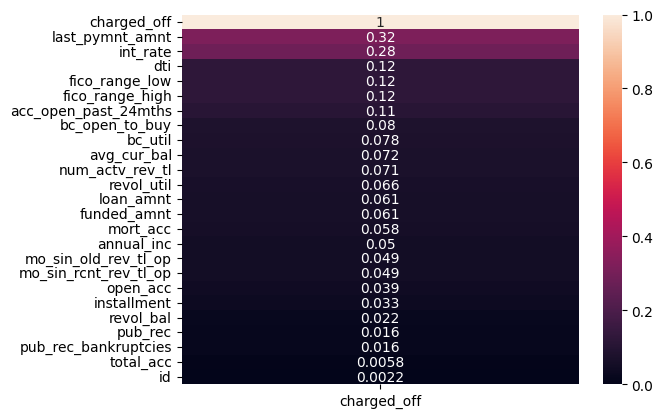

In [ ]:
sns.heatmap(
    abs(dataset.corr()[['charged_off']])
     .sort_values(by='charged_off',ascending=False),annot=True, vmax=1,vmin=0
    )
plt.show()

In [ ]:
correlaciones = abs(dataset.corr()['charged_off'])
drop_no_corr = correlaciones[correlaciones < 0.03].index

<ipython-input-17-7fe42f02652d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlaciones = abs(dataset.corr()['charged_off'])


In [ ]:
dataset.drop(drop_no_corr, axis=1, inplace=True)
dataset.shape

(86138, 34)

## Ingenieria de caracteristicas y analisis exploratorio

Hay algunas caraceteristicas como el codigo postal, la ocupacion o el titulo de trabajo que podrian proporcionar cierta informacion, sin embargo require de de un nuevo paso de limpieza de los datos, como la estandarizacion o agrupamiento de estas features para extraer cualquier informacion marginal. Con el fin se simplificar las cosas eliminaremos este tipo de caracteristicas

**Variables categoricas**

In [ ]:
dataset.drop(['emp_title','title','zip_code'], axis=1, inplace=True)

Ahora haremos una modificacion a la caracteristica `term`. Esta representa el numero de pagos de prestamo. Los valores son en meses y pueden ser de 36 o 60. Solo agregaremos 36 y 60.

Con un agrupamiento descubrimos que es mas probable que los prestamos a 60 meses se cobren

In [ ]:
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

In [ ]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True)

term  charged_off
36    0              0.858474
      1              0.141526
60    0              0.645644
      1              0.354356
Name: charged_off, dtype: float64

Otra caracteristica importante son los periodos de los prestamos. Pudimos descubrir que los periodos de 5 años tienen mas del doble de probabilidades de cobrarse que los prestamos con periodos de 3 años.

In [ ]:
dataset['emp_length'].replace('10+ years', '10 years', inplace=True)
dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
  if pd.isna(s):
    return s

  else:
    return np.int8(s.split()[0])

dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)

Esto se puede leer como: Para cada categoria de periodo, cuantos valores tengo en **fully paid (0)** y **charged off (1)**

In [ ]:
dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True)

emp_length  charged_off
0.0         0              0.799433
            1              0.200567
1.0         0              0.809741
            1              0.190259
2.0         0              0.820366
            1              0.179634
3.0         0              0.815743
            1              0.184257
4.0         0              0.824738
            1              0.175262
5.0         0              0.827395
            1              0.172605
6.0         0              0.811358
            1              0.188642
7.0         0              0.814273
            1              0.185727
8.0         0              0.808984
            1              0.191016
9.0         0              0.809067
            1              0.190933
10.0        0              0.818079
            1              0.181921
Name: charged_off, dtype: float64

Podemos observar 2 cosas:
1. La proporcion es similar a la proporcior orginal de nuestros datos
2. La distribucion de la variable de interes (1) se distribuye uniformemente


Con esto podemos concluir que el estado del prestamos no se ve influido por la duracion o peridos, por lo tanto eliminamos esta carcateristica

In [ ]:
dataset.drop(['emp_length'], axis=1, inplace=True)

Ahora veremos la caracteristica `subgrade`. Como observamos abajo a medida que empeora el grado existe cada vez mas probabilidad de charged_off. Por lo tanto es una caracteristca utila para el entrenamiento

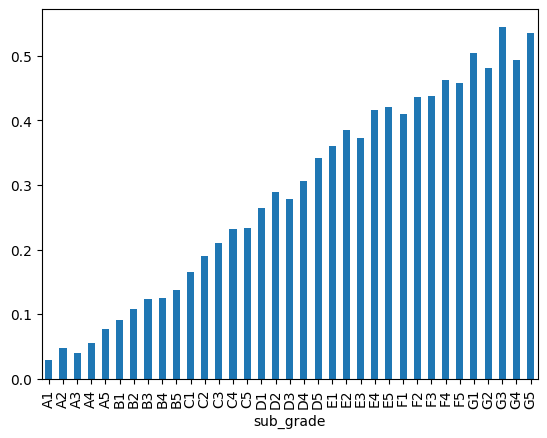

In [ ]:
charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates.plot(kind='bar')
plt.show()

**Variables continua**

Empezaremos analizando `annual_inc`. Los ingresos anuales oscilan entre 4000 a 7,000,000 con un mediana de 60,000. Debido a la amplia gamma de ingresos, utilizaremos una transformacion para esta variable.

In [ ]:
dataset[['annual_inc']].describe()

,annual_inc
count,8.613800e+04
mean,7.384311e+04
std,5.929352e+04
min,4.000000e+03
25%,4.500000e+04
50%,6.247372e+04
75%,9.000000e+04
max,7.500000e+06


In [ ]:
dataset['log_annual_inc'] = np.log10(dataset['annual_inc'])
dataset.drop('annual_inc', axis=1, inplace=True)

Ahora veremos la caracteristica FICO score

In [ ]:
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']
dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [ ]:
dataset['charged_off'].value_counts(normalize=True)

0    0.812441
1    0.187559
Name: charged_off, dtype: float64

## Encoding Datos Categoricos

El codificador `label encoder` codifica etiquetas con un valor entre 0 y **n**, donde **n** es el numero de etiquetas distintas

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
cat_features = dataset.dtypes[dataset.dtypes == object].index

In [ ]:
le =  LabelEncoder()
oh = OneHotEncoder()

In [ ]:
dataset[cat_features] = dataset[cat_features].apply(lambda col: le.fit_transform(col))

In [ ]:
dataset[cat_features].head()

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,initial_list_status,application_type
0,2,10,3,1,2,40,84,1,0
1,0,2,1,0,1,4,575,1,0
2,3,15,3,1,1,21,93,1,0
4,2,12,3,1,2,3,92,0,0
5,2,12,3,1,2,26,480,0,0


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = dataset['charged_off']
X = dataset.drop('charged_off', axis=1)

Rellenando datos faltantes

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
knn_impute = KNNImputer().set_output(transform='pandas')
X = knn_impute.fit_transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.20,
                                                    random_state=42,
                                                    stratify=y)

## Datos desequilibrados

Debido a que los datos estan desequilibrados (80-20) Tenemos que realizar alguna tecnica de remuestreo para lograr equilibrarlos. Esto lo puedemos realizar mediante 2 formas.
- SMOTE
- xgboost

In [ ]:
from imblearn.over_sampling import SMOTE


In [ ]:
x_resamp, y_resamp = SMOTE().fit_resample(x_train, y_train)

# Metricas de evaluacion

In [ ]:
num_folds = 10
seed = 7
scoring = 'roc_auc' # accuracy  precision  recall

## Comparacion de algoritmos

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [ ]:
modelos = {'lr': LogisticRegression(),
           'dt': DecisionTreeClassifier(),
           'knn': KNeighborsClassifier(),
           'rf': RandomForestClassifier(),
           'gbc': GradientBoostingClassifier(),
           'gnb': GaussianNB()}

resultados = {}

In [ ]:
for nombre, modelo in modelos.items():
  resultados[nombre] = cross_val_score(modelo,
                                       x_resamp,
                                       y_resamp,
                                       cv=10,
                                       scoring='roc_auc')

In [ ]:
resultados =  pd.DataFrame(resultados)

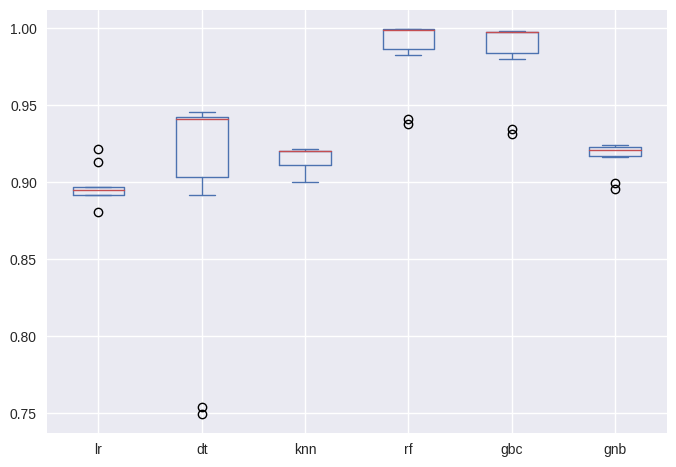

In [ ]:
pd.DataFrame(resultados).plot(kind='box')
plt.show()

## Mejoramiento y optimizacion del modelo

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
modelo = RandomForestClassifier()
modelo.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param_grid = {'n_estimators':[100,200,300,400],
              'max_depth':[2,4,6,8],
              'max_features':['sqrt','log2'],
              'criterion':['gini','entropy','log_loss']}

tun_model = RandomizedSearchCV(modelo,
                               param_grid,
                               cv=3,
                               scoring='roc_auc')
tun_model.fit(x_resamp,y_resamp)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 4, 6, 8],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [100, 200, 300, 400]},
                   scoring='roc_auc')

In [ ]:
tun_model.best_params_

{'n_estimators': 200,
 'max_features': 'log2',
 'max_depth': 8,
 'criterion': 'log_loss'}

In [ ]:
tun_model.best_score_

0.9722014568245617

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
predicciones = tun_model.predict(x_test)
score = accuracy_score(y_test, predicciones)

In [ ]:
score

0.8619108428140236